In [72]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
import os.path
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.preprocessing import quantile_transform

from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn import metrics


#sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Levanto toda la data

In [75]:
#df_merged_all = pd.read_pickle('../sources/df_merged_all_quantiles_mediana_iqr.pickle')
df_merged_all = pd.read_pickle('../sources/df_todo_1_Normalized.pickle')
list(df_merged_all.columns)

['af_duration_ms',
 'af_popularity',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature',
 'aa_confidence_mediana',
 'aa_loudness_start_mediana',
 'aa_loudness_max_time_mediana',
 'aa_loudness_max_mediana',
 'aa_loudness_end_mediana',
 'aa_p00_C_mediana',
 'aa_p01_C#_mediana',
 'aa_p02_D_mediana',
 'aa_p03_D#_mediana',
 'aa_p04_E_mediana',
 'aa_p05_F_mediana',
 'aa_p06_F#_mediana',
 'aa_p07_G_mediana',
 'aa_p08_G#_mediana',
 'aa_p09_A_mediana',
 'aa_p10_A#_mediana',
 'aa_p11_B_mediana',
 'aa_t00_mediana',
 'aa_t01_mediana',
 'aa_t02_mediana',
 'aa_t03_mediana',
 'aa_t04_mediana',
 'aa_t05_mediana',
 'aa_t06_mediana',
 'aa_t07_mediana',
 'aa_t08_mediana',
 'aa_t09_mediana',
 'aa_t10_mediana',
 'aa_t11_mediana',
 'aa_confidence_iqr',
 'aa_loudness_start_iqr',
 'aa_loudness_max_time_iqr',
 'aa_loudness_max_iqr',
 'aa_loudness_end_iqr',
 'aa_p

Selecciono las variables, que son con las que voy a proceder en el resto del trabajo.

Así que empiezo a remover las variables que considero que no me van a ayudar para una apropiada clasificacion que genere algún sentido de explicación

In [94]:
    df_num = df_merged_all.drop(['af_instrumentalness','af_mode','af_popularity','af_time_signature','af_key'],1)


    cols = [c for c in df_num.columns if c.lower()[:15] != 'aa_loudness_end']
    df_num=df_num[cols]
    cols = [c for c in df_num.columns if c.lower()[:18] != 'aa_confidence_dif_']
    df_num=df_num[cols]

    cols = [c for c in df_num.columns if not (c.lower()[:5] == 'aa_t0' and c.lower()[:6] != 'aa_t00' and c.lower()[:6] != 'aa_t01' and c.lower()[:6] != 'aa_t02')]
    df_num=df_num[cols]
    cols = [c for c in df_num.columns if not (c.lower()[:5] == 'aa_t1')]
    df_num=df_num[cols]
    cols = [c for c in df_num.columns if not (c.lower()[:5] == 'aa_p0')]
    df_num=df_num[cols]
    cols = [c for c in df_num.columns if not (c.lower()[:5] == 'aa_p1')]
    df_num=df_num[cols]
    #df_num.head(5).T

    list(df_num.columns)

['af_duration_ms',
 'af_danceability',
 'af_energy',
 'af_loudness',
 'af_speechiness',
 'af_acousticness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'aa_confidence_mediana',
 'aa_loudness_start_mediana',
 'aa_loudness_max_time_mediana',
 'aa_loudness_max_mediana',
 'aa_t00_mediana',
 'aa_t01_mediana',
 'aa_t02_mediana',
 'aa_confidence_iqr',
 'aa_loudness_start_iqr',
 'aa_loudness_max_time_iqr',
 'aa_loudness_max_iqr',
 'aa_t00_iqr',
 'aa_t01_iqr',
 'aa_t02_iqr',
 'aa_loudness_start_dif_mediana',
 'aa_loudness_max_time_dif_mediana',
 'aa_loudness_max_dif_mediana',
 'aa_t00_dif_mediana',
 'aa_t01_dif_mediana',
 'aa_t02_dif_mediana',
 'aa_loudness_start_dif_iqr',
 'aa_loudness_max_time_dif_iqr',
 'aa_loudness_max_dif_iqr',
 'aa_t00_dif_iqr',
 'aa_t01_dif_iqr',
 'aa_t02_dif_iqr',
 'genre']

Me guardo el dataset, porque con este sigo en el resto del trabajo.

In [95]:
df_num.to_pickle("../sources/df_merged_posta_preprocesado.pickle")

genre_real = df_num['genre']

df_num = df_num.drop('genre',1)

Miro cómo quedó la distribución de las variables que voy a analizar.
Todas bien normalizadas.
Si alguna tuviera una distribución rara, sobresaldría del espectro

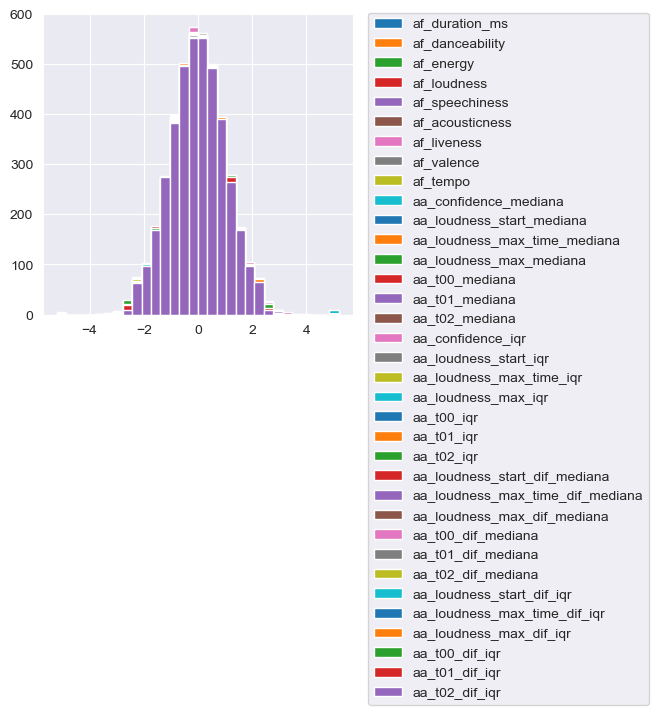

In [96]:
# 
cols = df_num.columns
for k in cols:
    df_num[k].hist(bins=30)
plt.legend(cols,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Y ahora aplico el t-SNE.

In [97]:
df=df_num
tsne = TSNE(n_components=2, perplexity=20, init='pca')
Xred = tsne.fit_transform(df)

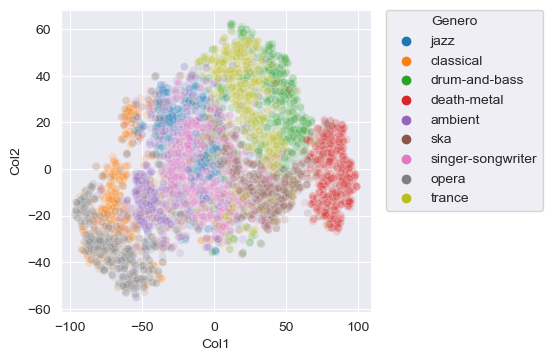

In [98]:
dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Genero":genre_real.values})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Quedó con buenos agrupamientos.
Quizás no perfectamente segregados, pero sí se notan muy buenos delineamientos y tendencias que ayudan a un buen entendimiento del dataset.
El t-SNE da un soporte muy bueno para la visualización de esta información.

Podemos ver que un grupo que está altamente segregado del resto es death-metal. Cuya mayor relación parece encontrarse con los géneros drum-and-bass y ska (y no coincidentemente, son los géneros más pesados del set).

Después hay un agrupamiento bastante particular donde drum-and-bass y trance se encuentran en un extremo del set, siendo que también se condice con los géneros más movidos.

En el otro extremo del dataset se encuentran la música clásica y la ópera, con un cierto solapamiento el uno con el otro.
Y no coincidentemente está la música ambiente cerca de ellos. Estos tres géneros son los más "serenos?".

Las canciones de jazz y singer-songwriter se encuentran solapadas en la visualización, en una posición céntrica y son las más esparcidas.
Esto puede ser indicador de que son las más "balanceadas" del set, siendo los géneros más versátiles del dataset.

Vamos a hacer una prueba rápida del dataset y un clustering por k-meoides, para ver cómo anda. Después lo analizamos mejor... Esto es nomás para dar un panorama general

In [100]:
def plot_conf_matrix(real, Z2, description, nclust):
    mat = confusion_matrix(real, Z2)
    if(len(mat)==len(genres)):
        sns.heatmap(mat, square=False, annot=True, fmt='d', cbar=False,
                    yticklabels=genres,
                    xticklabels=range(nclust))
    else:
        sns.heatmap(mat[nclust:nclust+len(genres),0:nclust], square=False, annot=True, fmt='d', cbar=False,
                    yticklabels=genres,
                    xticklabels=range(nclust))
    plt.ylabel('Real')
    plt.xlabel(description);
    plt.show()

Vemos la cantidad de grupos que deseamos generar

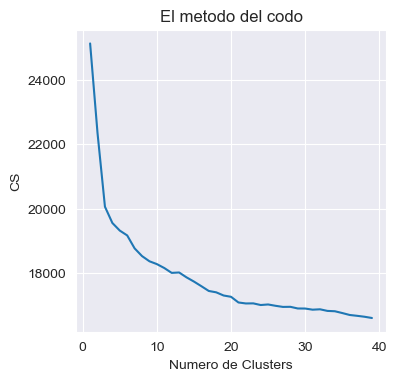

In [101]:
from sklearn.cluster import KMeans

cs = []
for i in range(1, 40):
    kmeans = KMedoids(metric="euclidean", n_clusters=i, max_iter = 3000, random_state = 0, init='k-medoids++')
    #kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_num)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 40), cs)
plt.title('El metodo del codo')
plt.xlabel('Numero de Clusters')
plt.ylabel('CS')
plt.show()

In [102]:
len(df_num.columns)
n=9
letra = ['A','B','C','D','E','F','G','H','I','J',]
model = KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++')
model.fit(df_num)
Z = model.predict(df_num)
Z2 = [letra[x] for x in Z]

print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(df_num, Z)))
#print("Homogeneity score for k == {}: {}".format(k, metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)))


Silhouette Coefficient for k == aa_t02_dif_iqr: 0.07584964136385489


Con este gráfico, si se sigue la regla del codo, entonces diría que usemos 9 grupos.|

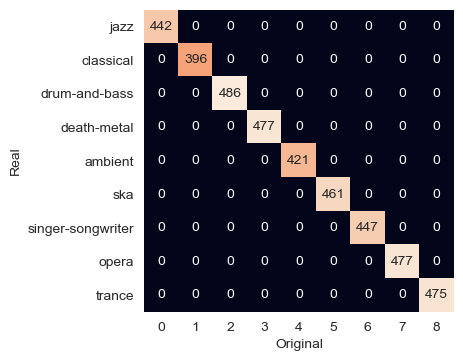

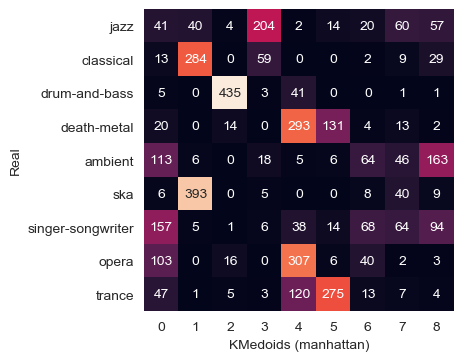

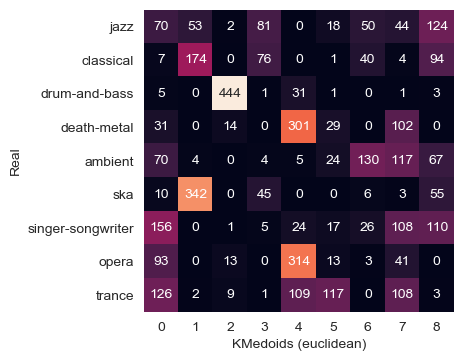

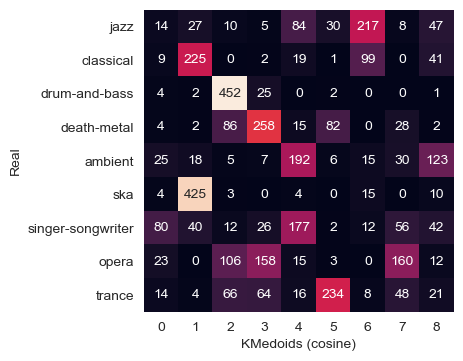

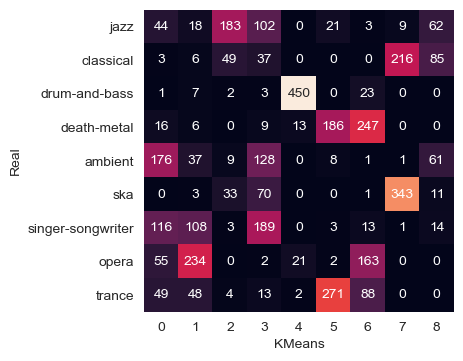

In [103]:
n=9
np.random.seed(3569)

genres = genre_real.unique()

plot_conf_matrix(genre_real.values, genre_real.values,'Original',9)

selected_models = [
    (
        KMedoids(metric="manhattan", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++'),
        "KMedoids (manhattan)",
    ),
    (
        KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++'),
        "KMedoids (euclidean)",
    ),
    (
        KMedoids(metric="cosine", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++'),
        "KMedoids (cosine)"
    ),
    (KMeans(n_clusters=n, max_iter = 300, random_state = 0), "KMeans"),
]

for i, (model, description) in enumerate(selected_models):
    model.fit(df_num)
    Z = model.predict(df_num)
    Z2 = [str(x) for x in Z]
    #print(description)
    #print(confusion_matrix(genre_real.values, Z2))
    plot_conf_matrix(genre_real.values, Z2, description, n)

In [104]:
len(df_num.columns)

35

In [105]:
letra = ['A','B','C','D','E','F','G','H','I','J',]
model = KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 1, init='k-medoids++')
model.fit(df_num)
Z = model.predict(df_num)
Z2 = [letra[x] for x in Z]

Y este es el clustering con k meoides. creo q hay bastante q se asocia bien.

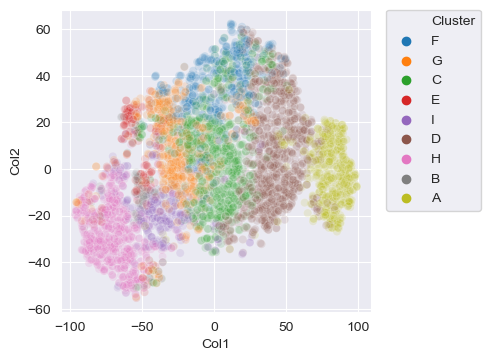

In [106]:
import seaborn as sns

df=df_num.iloc[:,:]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#    plt._legend.set_title()
plt.show()
